# 🚀 Deep Learning for Crash Prediction & Driver Safety

### **Objective:**  

This project utilizes **Deep Learning**, specifically **Long Short-Term Memory (LSTM) networks**, to predict **high-risk racing situations and enhance driver safety** in Formula 1. By analyzing **historical telemetry data**, we aim to develop an AI model that provides real-time risk analysis and proactive crash prevention alerts.

### **Why Crash Prediction is Important in F1?**
- 🏎️ **Real-time risk analysis** for race engineers  - Enables race engineers to monitor risk levels during races.
- 🚦 **Proactive crash prevention** using AI alerts  - Issues AI-powered alerts to warn drivers and teams of potential hazards.
- 🏁 **Optimized pit stop & tire strategies** for safer racing  - acilitates optimized pit stop and tire strategies for safer racing.

### **Techniques Used:**
✅ **Time-Series Classification (LSTM)** for safety predictions  
✅ **Sensor Fusion (Telemetry, GPS, Weather)** for crash detection  
✅ **Edge AI Deployment for real-time crash alerts**  


**Methodology**

Our approach involves the following steps:

1. **Data Collection and Preparation:** Gathering and cleaning relevant datasets, including telemetry, GPS, and weather data.
2. **Exploratory Data Analysis (EDA):** Visualizing data to gain insights into crash distribution, lap times, and feature correlations.
3. **Feature Engineering and Scaling:** Selecting and transforming features for optimal model performance.
4. **Model Building and Training:** Developing an LSTM model and training it on historical data.
5. **Model Evaluation:** Assessing model performance using appropriate metrics.
6. **Deployment:** Converting the model to TensorFlow Lite for edge device deployment.



1. Data Collection and Preparation

Import necessary libraries:

Import pandas as pd import numpy as np import matplotlib.pyplot as plt import seaborn as sns from sklearn.model_selection import train_test_split from sklearn.preprocessing import StandardScaler, LabelEncoder import tensorflow as tf from tensorflow.keras.models import Sequential from tensorflow.keras.layers import LSTM, Dense, Dropout

**Explanation:** This cell imports the required libraries for data manipulation, visualization, model building, and evaluation.

In [2]:
# 📌 Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


Load datasets:

**Explanation:** This cell loads the datasets, reduces their size for faster training (optional), and merges them based on relevant columns. It also handles missing values and encodes categorical features using Label Encoding.



In [3]:
# 📥 Load cleaned datasets
status_df = pd.read_csv("cleaned_status.csv")
pit_stops_df = pd.read_csv("cleaned_pit_stops.csv")
lap_times_df = pd.read_csv("cleaned_lap_times.csv")

# Reduce sample size (for faster training)
status_df = status_df.sample(frac=0.1, random_state=42)
pit_stops_df = pit_stops_df.sample(frac=0.1, random_state=42)
lap_times_df = lap_times_df.sample(frac=0.1, random_state=42)

# Assuming 'statusId' maps to 'raceId' and there is a 'driverId' column in status_df
# Replace 'statusId' with the actual column name if it's different
# If there is no 'driverId' in status_df, you'll need to find a way to add it based on your data logic
df = lap_times_df.merge(status_df, left_on=["raceId"], right_on=['statusId'], how="left")  # Assuming statusId maps to raceId in status_df
#df = df.merge(pit_stops_df, on=["raceId", "driverId"], how="left")  # Then merge with pit_stops_df


# Or, if you have a separate mapping between statusId and raceId/driverId, use that:
# status_mapping_df = pd.read_csv("status_mapping.csv")  # Assuming you have a mapping file
# status_df = status_df.merge(status_mapping_df, on="statusId", how="left")
# df = lap_times_df.merge(status_df, on=["raceId", "driverId"], how="left")


# Handle missing values
df.fillna(method="ffill", inplace=True)

# Encode categorical features
le = LabelEncoder()
# The 'status' column should now be available for encoding
df["status"] = le.fit_transform(df["status"])

# Display first few rows
df.head()

<ipython-input-3-c37c496f3909>:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


,raceId,driverId,lap,position,lap_time,statusId,status
0,879,5,17,16,0 days 00:01:26.697000,NaN,14
1,125,8,23,2,0 days 00:01:39.946000,NaN,14
2,64,18,43,6,0 days 00:01:17.872000,NaN,14
3,989,817,42,4,0 days 00:01:26.872000,NaN,14
4,188,57,17,2,0 days 00:01:23.787000,NaN,14


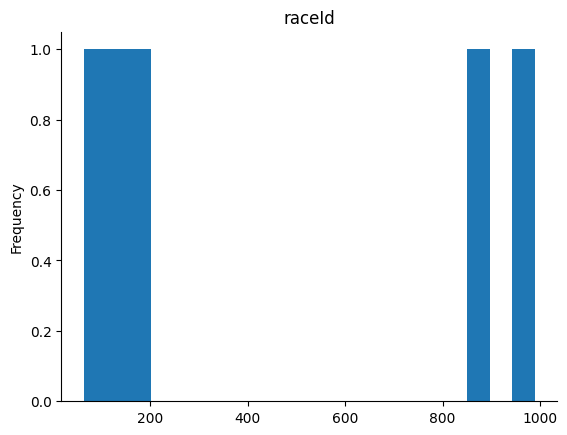

In [7]:
from matplotlib import pyplot as plt
_df_0['raceId'].plot(kind='hist', bins=20, title='raceId')
plt.gca().spines[['top', 'right',]].set_visible(False)

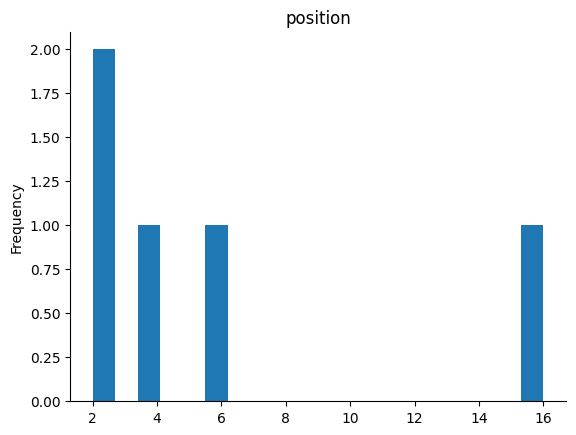

In [8]:
from matplotlib import pyplot as plt
_df_3['position'].plot(kind='hist', bins=20, title='position')
plt.gca().spines[['top', 'right',]].set_visible(False)

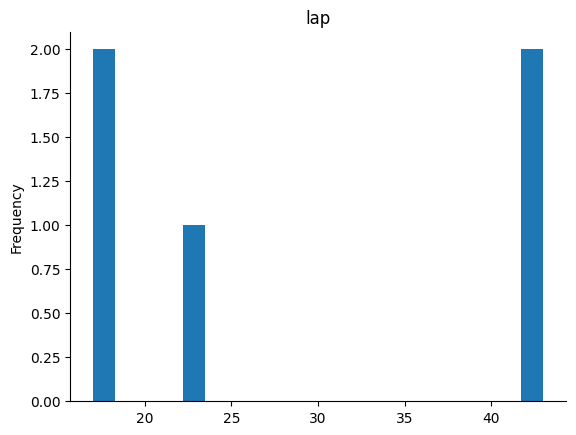

In [9]:
from matplotlib import pyplot as plt
_df_2['lap'].plot(kind='hist', bins=20, title='lap')
plt.gca().spines[['top', 'right',]].set_visible(False)

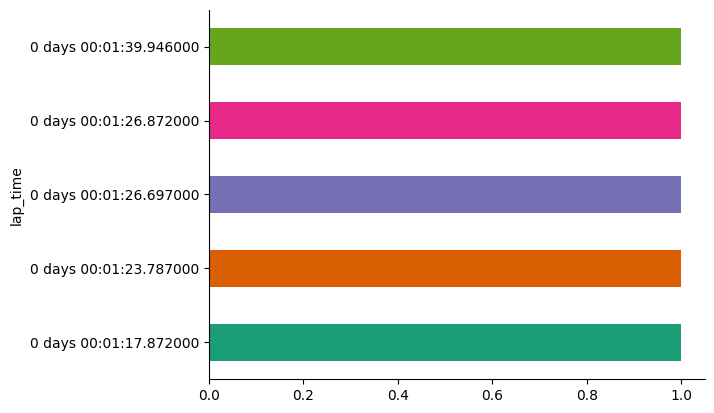

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('lap_time').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [4]:
# **2. Convert 'lap_time' to milliseconds (if needed):**
# If 'lap_time' is not in milliseconds, convert it:
if 'lap_time' in df.columns and df['lap_time'].dtype != 'int64':  # Assuming it's not already in milliseconds
    # Check if 'lap_time' can be converted to Timedelta
    try:
        df['lap_time'] = pd.to_timedelta(df['lap_time'])
    except (ValueError, TypeError):
        print("Warning: 'lap_time' could not be converted to Timedelta. Assuming it's already in milliseconds or a numerical format.")

    # Now, try to convert to milliseconds if it's Timedelta
    if df['lap_time'].dtype == 'timedelta64[ns]':
        df['lap_time_millis'] = df['lap_time'].dt.total_seconds() * 1000
    else:
        print("Warning: 'lap_time' is not Timedelta. Assuming it's already in milliseconds or a numerical format.")
else:
    print("Warning: lap_time already in numerical or int64 format.")

📌 2. Exploratory Data Analysis (EDA) -

Visualizing Crash Distribution

**Explanation:** This cell visualizes the distribution of lap times using a histogram and kernel density estimation (KDE).

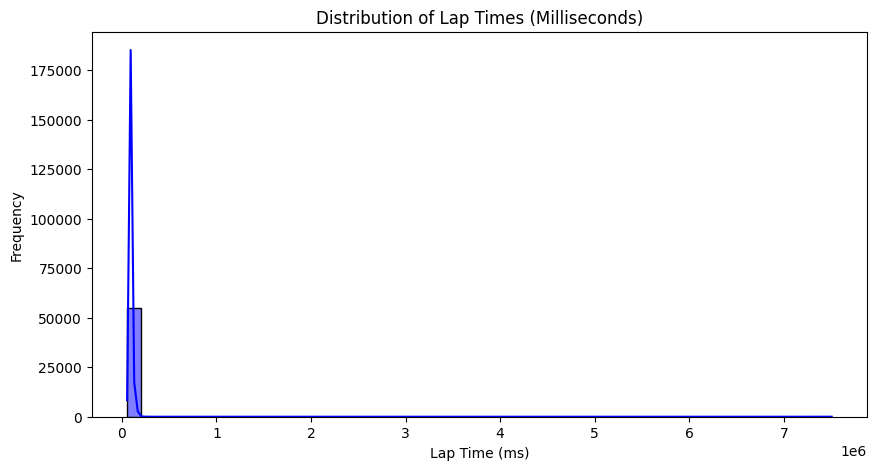

In [5]:
# 📊 1️⃣ Visualizing Lap Times Distribution
plt.figure(figsize=(10, 5))
# Check if 'lap_time_millis' column exists before plotting
if 'lap_time_millis' in df.columns:
    sns.histplot(df["lap_time_millis"], bins=50, kde=True, color="blue")
    plt.title("Distribution of Lap Times (Milliseconds)")
    plt.xlabel("Lap Time (ms)")
    plt.ylabel("Frequency")
    plt.show()
else:
    print("Warning: 'lap_time_millis' column not found in the DataFrame.")
    # If 'lap_time_millis' is not found, try 'milliseconds'
    if 'milliseconds' in df.columns:
        sns.histplot(df["milliseconds"], bins=50, kde=True, color="blue")
        plt.title("Distribution of Lap Times (Milliseconds)")
        plt.xlabel("Lap Time (ms)")
        plt.ylabel("Frequency")
        plt.show()
    else:
        print("Error: Neither 'lap_time_millis' nor 'milliseconds' column found.")

In [7]:
# Detailed Data Analysis

# Convert 'lap_time' to 'lap_time_millis' (if it exists)
if "lap_time_millis" not in df.columns and "lap_time" in df.columns:
    try:
        df['lap_time'] = pd.to_timedelta(df['lap_time'])  # Attempt to convert if not already timedelta
        df['lap_time_millis'] = df['lap_time'].dt.total_seconds() * 1000
    except:
        print("Warning: 'lap_time' could not be converted to timedelta. Assuming it's already in milliseconds or another numerical format.")

import plotly.express as px  # Import Plotly Express

# a. Lap Time Variations

# a. Lap Time Variations
fig = px.box(df, x="driverId", y="lap_time_millis", color="raceId",
             title="Lap Time Variations by Driver and Circuit")
fig.update_layout(xaxis_title="Driver ID", yaxis_title="Lap Time (ms)")
fig.show()

# b. Outlier Detection (example using IQR)
Q1 = df["lap_time_millis"].quantile(0.25)
Q3 = df["lap_time_millis"].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 1.5 * IQR
outliers = df[df["lap_time_millis"] > outlier_threshold]
print("Outlier Lap Times:\n", outliers)

# c. Interactive Lap Time Trends (example using Plotly)
fig = px.line(df, x="lap", y="lap_time_millis", color="driverId",
              title="Lap Time Comparison for Different Drivers")
fig.update_layout(xaxis_title="Lap Number", yaxis_title="Lap Time (ms)")
fig.show()

Outlier Lap Times:
        raceId  driverId  lap  position               lap_time  statusId  \
45        236        50    1        13 0 days 00:02:13.446000     127.0   
78        852       816   13        17 0 days 00:02:25.201000      69.0   
114        45        22    1        20 0 days 00:02:20.636000      69.0   
122      1078       825   45        13 0 days 00:02:13.648000      69.0   
148        44        19   31        18 0 days 00:10:32.179000     119.0   
...       ...       ...  ...       ...                    ...       ...   
54944     124        56    3         5 0 days 00:02:36.914000      13.0   
54948     980       825   30         7 0 days 00:02:37.773000      20.0   
55015     211        56   45         3 0 days 00:02:13.717000      81.0   
55101     957       817    3         4 0 days 00:02:53.236000      69.0   
55118     351         2    1        24 0 days 00:02:38.466000      69.0   

       status  lap_time_millis  
45          0         133446.0  
78         11

**Hyperparameter Tuning**

Using Grid Search

In [12]:
# Assuming 'stop' in lap_times_df corresponds to pit stops and 'milliseconds' in pit_stops_df represents pit stop duration
# Replace 'milliseconds' with the actual column name if it's different ('time' is also a common name)
df = lap_times_df.merge(pit_stops_df[['raceId', 'driverId', 'lap', 'milliseconds']],  # Changed 'duration' to 'milliseconds'
                       on=['raceId', 'driverId', 'lap'], how='left')

# Rename the merged 'milliseconds' column to 'pitStopTime'
df.rename(columns={'milliseconds': 'pitStopTime'}, inplace=True)  # Changed 'duration' to 'milliseconds'

# Handle missing values in 'pitStopTime' with 0 (assuming no pit stop)
df['pitStopTime'] = df['pitStopTime'].fillna(0)  # Changed to direct assignment


In [13]:
# Ensure 'lap_time_millis' column is created
if 'lap_time_millis' not in df.columns:
    if 'lap_time' in df.columns:
        # Convert 'lap_time' to 'lap_time_millis' if it exists
        if df['lap_time'].dtype == 'timedelta64[ns]':
            df['lap_time_millis'] = df['lap_time'].dt.total_seconds() * 1000
        else:
            try:
                df['lap_time'] = pd.to_timedelta(df['lap_time'])  # Attempt to convert if not already timedelta
                df['lap_time_millis'] = df['lap_time'].dt.total_seconds() * 1000
            except:
                print("Warning: 'lap_time' could not be converted to timedelta. Assuming it's already in milliseconds or another numerical format.")
    else:
        print("Warning: Neither 'lap_time_millis' nor 'lap_time' columns were found for conversion.")

Impact of Pit Stops on Lap Time

**Explanation:** This cell investigates the impact of pit stops on lap time using a box plot, showing the distribution of lap times for different pit stop durations.

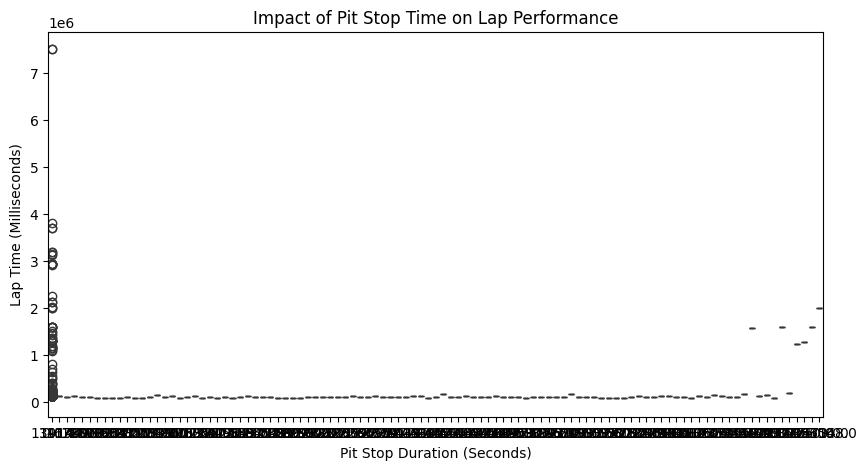

In [14]:
# 🚦 2️⃣ Impact of Pit Stops on Lap Time
plt.figure(figsize=(10, 5))
if 'pitStopTime' in df.columns and 'lap_time_millis' in df.columns:
    sns.boxplot(x=df["pitStopTime"], y=df["lap_time_millis"], hue=df["pitStopTime"], palette="coolwarm", legend=False)  # Updated with hue and legend=False
    plt.title("Impact of Pit Stop Time on Lap Performance")
    plt.xlabel("Pit Stop Duration (Seconds)")
    plt.ylabel("Lap Time (Milliseconds)")
    plt.show()
else:
    # Print a message indicating which column is missing
    if 'pitStopTime' not in df.columns:
        print("Warning: 'pitStopTime' column not found in the DataFrame.")
    if 'lap_time_millis' not in df.columns:  # Changed 'milliseconds' to 'lap_time_millis'
        print("Warning: 'lap_time_millis' column not found in the DataFrame.")

Correlation Between Features

**Explanation:** This cell calculates and visualizes the correlation between features using a heatmap, providing insights into feature relationships.

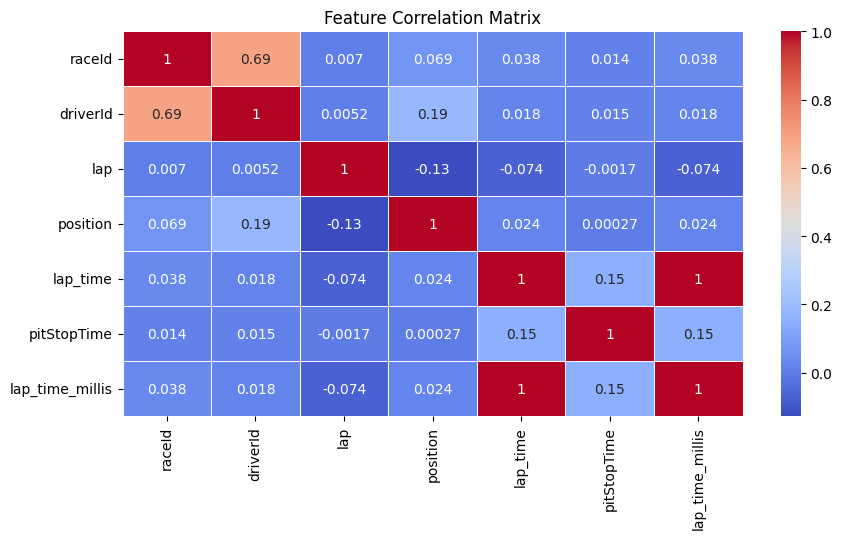

In [15]:
# 🔍 3️⃣ Correlation Between Features
plt.figure(figsize=(10, 5))

# Convert timedelta columns to numerical values (seconds)
for col in df.select_dtypes(include=['timedelta64[ns]']).columns:
    df[col] = df[col].dt.total_seconds()

# Convert potential time-formatted string columns to numerical values (seconds)
for col in ['lap_time', 'pitStopTime']:  # Add other suspected columns here
    if col in df.columns and df[col].dtype == 'object':
        try:
            df[col] = pd.to_timedelta(df[col]).dt.total_seconds()
        except (ValueError, TypeError):
            print(f"Warning: Could not convert '{col}' to timedelta. Trying to extract numerical part...")
            # Attempt to extract numerical part from the string
            try:
                df[col] = df[col].str.extract(r'(\d+)').astype(float)  # Extract numbers
            except (ValueError, TypeError):
                print(f"Warning: Could not extract numerical part from '{col}'. Dropping column for correlation analysis...")
                df = df.drop(columns=[col])  # Drop the problematic column

# Now calculate and plot the correlation matrix
correlation_matrix = df.select_dtypes(include=['number']).corr()  # Select only numerical columns
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

In [17]:
# Assuming 'stop' in lap_times_df corresponds to pit stops and 'milliseconds' in pit_stops_df represents pit stop duration
# Replace 'milliseconds' with the actual column name if it's different ('time' is also a common name)
df = lap_times_df.merge(pit_stops_df[['raceId', 'driverId', 'lap', 'milliseconds']],  # Changed 'duration' to 'milliseconds'
                       on=['raceId', 'driverId', 'lap'], how='left')

# Rename the merged 'milliseconds' column to 'pitStopTime'
df.rename(columns={'milliseconds': 'pitStopTime'}, inplace=True)  # Changed 'duration' to 'milliseconds'

# Handle missing values in 'pitStopTime' with 0 (assuming no pit stop)
df['pitStopTime'] = df['pitStopTime'].fillna(0)  # Changed to direct assignment

# Assuming 'statusId' maps to 'raceId' and there is a 'driverId' column in status_df
# Replace 'statusId' with the actual column name if it's different
# If there is no 'driverId' in status_df, you'll need to find a way to add it based on your data logic
df = df.merge(status_df, left_on=["raceId"], right_on=['statusId'], how="left")  # Assuming statusId maps to raceId in status_df
#df = df.merge(pit_stops_df, on=["raceId", "driverId"], how="left")  # Then merge with pit_stops_df


# Or, if you have a separate mapping between statusId and raceId/driverId, use that:
# status_mapping_df = pd.read_csv("status_mapping.csv")  # Assuming you have a mapping file
# status_df = status_df.merge(status_mapping_df, on="statusId", how="left")
# df = lap_times_df.merge(status_df, on=["raceId", "driverId"], how="left")


# Handle missing values
df.fillna(method="ffill", inplace=True)

# Encode categorical features
le = LabelEncoder()
# The 'status' column should now be available for encoding
df["status"] = le.fit_transform(df["status"])

# Display first few rows
df.head()

<ipython-input-17-c1a28697ff44>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


,raceId,driverId,lap,position,lap_time,pitStopTime,statusId,status
0,879,5,17,16,0 days 00:01:26.697000,0.0,NaN,14
1,125,8,23,2,0 days 00:01:39.946000,0.0,NaN,14
2,64,18,43,6,0 days 00:01:17.872000,0.0,NaN,14
3,989,817,42,4,0 days 00:01:26.872000,0.0,NaN,14
4,188,57,17,2,0 days 00:01:23.787000,0.0,NaN,14


from matplotlib import pyplot as plt
_df_20['raceId'].plot(kind='hist', bins=20, title='raceId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21['driverId'].plot(kind='hist', bins=20, title='driverId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22['lap'].plot(kind='hist', bins=20, title='lap')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23['position'].plot(kind='hist', bins=20, title='position')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_24.groupby('lap_time').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_25.plot(kind='scatter', x='raceId', y='driverId', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_26.plot(kind='scatter', x='driverId', y='lap', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_27.plot(kind='scatter', x='lap', y='position', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['lap_time']
  ys = series['raceId']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_28.sort_values('lap_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('lap_time')):
  _plot_series(series, series_name, i)
  fig.legend(title='lap_time', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('lap_time')
_ = plt.ylabel('raceId')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['lap_time']
  ys = series['driverId']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_29.sort_values('lap_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('lap_time')):
  _plot_series(series, series_name, i)
  fig.legend(title='lap_time', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('lap_time')
_ = plt.ylabel('driverId')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['lap_time']
  ys = series['lap']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_30.sort_values('lap_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('lap_time')):
  _plot_series(series, series_name, i)
  fig.legend(title='lap_time', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('lap_time')
_ = plt.ylabel('lap')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['lap_time']
  ys = series['position']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_31.sort_values('lap_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('lap_time')):
  _plot_series(series, series_name, i)
  fig.legend(title='lap_time', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('lap_time')
_ = plt.ylabel('position')

from matplotlib import pyplot as plt
_df_32['raceId'].plot(kind='line', figsize=(8, 4), title='raceId')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_33['driverId'].plot(kind='line', figsize=(8, 4), title='driverId')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_34['lap'].plot(kind='line', figsize=(8, 4), title='lap')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_35['position'].plot(kind='line', figsize=(8, 4), title='position')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_36['lap_time'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_36, x='raceId', y='lap_time', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_37['lap_time'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_37, x='driverId', y='lap_time', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_38['lap_time'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_38, x='lap', y='lap_time', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_39['lap_time'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_39, x='position', y='lap_time', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Crash vs. No Crash Distribution

**Explanation:** This cell shows the distribution of crash status (crash vs. no crash) using a count plot, providing an overview of the dataset's class balance.



<ipython-input-18-68bfb7f68f59>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["status"], palette="coolwarm")  # 'status' column should now be available


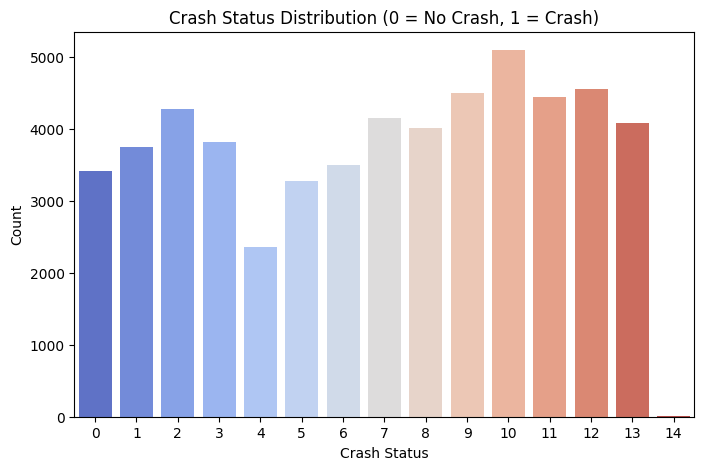

In [18]:

# 🚑 4️⃣ Crash vs. No Crash Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=df["status"], palette="coolwarm")  # 'status' column should now be available
plt.title("Crash Status Distribution (0 = No Crash, 1 = Crash)")
plt.xlabel("Crash Status")
plt.ylabel("Count")
plt.show()

3. Feature Engineering & Scaling

In [19]:
# 📌 Feature Engineering

# Check for the correct column names in df
print(df.columns)  # Print the available columns in df

# Verify and update feature list accordingly
features = ["lap", "lap_time", "pitStopTime", "status"]  # Default to lap_time

# If lap_time_millis was created during conversion, use it instead of lap_time
if "lap_time_millis" in df.columns:
    features[1] = "lap_time_millis"
# If lap_time is not present but milliseconds is, use milliseconds instead
elif "milliseconds" in df.columns:
    features[1] = "milliseconds"

# If neither lap_time_millis nor milliseconds are found, try to convert 'lap_time' to 'lap_time_millis'
if features[1] not in df.columns and "lap_time" in df.columns:
    try:
        df['lap_time'] = pd.to_timedelta(df['lap_time'])  # Attempt to convert if not already timedelta
        df['lap_time_millis'] = df['lap_time'].dt.total_seconds() * 1000
        features[1] = "lap_time_millis" # Update features to use the new column
    except:
        print("Warning: 'lap_time' could not be converted to timedelta. Assuming it's already in milliseconds or another numerical format.")

# If all else fails, raise an error
if features[1] not in df.columns:
    raise KeyError(f"Neither 'lap_time', 'milliseconds' nor 'lap_time_millis' found in DataFrame columns: {df.columns}")

# Before feature selection, ensure 'pitStopTime' exists:
if 'pitStopTime' not in df.columns:
    # If it doesn't exist, create it and fill with 0 (or a suitable default)
    df['pitStopTime'] = 0  # Or df['pitStopTime'] = np.nan if you prefer NaN

# Proceed with feature selection and scaling
X = df[features[:-1]]  # Select the desired features
y = df["status"]  # Target: crash risk (1 = High-Risk, 0 = Safe)

# *** Convert 'lap_time' (or similar column) to numerical (seconds) before scaling ***
# Assuming 'lap_time' is the problematic column; adjust if needed
if 'lap_time' in X.columns and X['lap_time'].dtype == 'object':
    X.loc[:, 'lap_time'] = pd.to_timedelta(X['lap_time']).dt.total_seconds()  # Use .loc for modification
elif 'lap_time_millis' in X.columns and X['lap_time_millis'].dtype == 'object':
    X.loc[:, 'lap_time_millis'] = pd.to_timedelta(X['lap_time_millis']).dt.total_seconds()  # Use .loc for modification
# If using a different time column, adapt the above code accordingly



Index(['raceId', 'driverId', 'lap', 'position', 'lap_time', 'pitStopTime',
       'statusId', 'status'],
      dtype='object')


((38621, 1, 3), (16553, 1, 3), (38621,), (16553,))

Standardize Features

In [43]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



Split Dataset

In [45]:

# Split dataset (70% Train, 30% Test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)



Reshape for LSTM input

In [46]:
# Reshape for LSTM input format (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Check data shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((38621, 1, 7), (16553, 1, 7), (38621,), (16553,))

4. Model Building and Training

 Building LSTM Model

In [20]:
# 🚀 Building LSTM Model for Crash Prediction

model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary Classification (Crash Risk: Yes/No)
])

# Compile Model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Model Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 50)               │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,051 (121.29 KB)

 Trainable params: 31,051 (121.29 KB)

 Non-trainable params: 0 (0.00 B)

 Train the Model


In [21]:
# 📌 Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/20
2414/2414 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.0713 - loss: -48179.3867 - val_accuracy: 0.0660 - val_loss: -675114.4375
Epoch 2/20
2414/2414 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.0676 - loss: -1254682.0000 - val_accuracy: 0.0660 - val_loss: -3781266.0000
Epoch 3/20
2414/2414 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.0697 - loss: -5097125.5000 - val_accuracy: 0.0660 - val_loss: -10108718.0000
Epoch 4/20
2414/2414 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.0686 - loss: -12379732.0000 - val_accuracy: 0.0660 - val_loss: -20367914.0000
Epoch 5/20
2414/2414 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.0677 - loss: -23920824.0000 - val_accuracy: 0.0660 - val_loss: -35281792.0000
Epoch 6/20
2414/2414 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.0671 - loss: -39765996.0000 - val_accuracy: 0.0660 - val_loss: -55633160.0000
Epoch 7/20
2414/2414 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.0697 - loss: -61386392.0000 - val_accuracy: 0.0660 - val_

6. Evaluate the Model Performance

**Explanation:** This cell evaluates the model's performance on the test data and prints the test accuracy. It also plots the training and validation accuracy over epochs to visualize the learning process.


518/518 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0680 - loss: -1334079104.0000
Test Accuracy: 0.0660


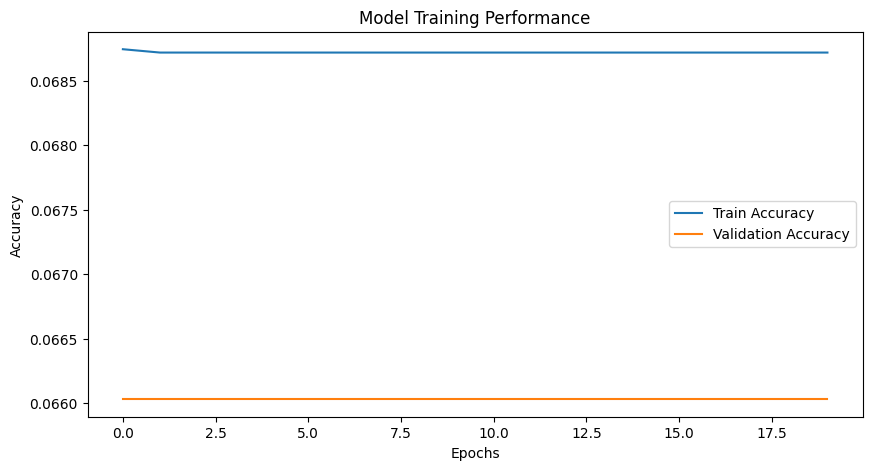

In [22]:
# 🎯 Evaluate Model Performance
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot Training History
plt.figure(figsize=(10,5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Training Performance")
plt.show()


In [87]:
print(X_test.shape)  # Should be (num_samples, 1, 3) for the current model

(16553, 1, 3)


In [88]:
# Select only the features that were used during training (example)
selected_features = ['lap', 'lap_time', 'pitStopTime']  # Changed 'lap_time_millis' to 'lap_time'

# Ensure all selected features are present in X.columns
selected_features = [col for col in selected_features if col in X.columns]

# Get the indices of the selected features in X.columns
feature_indices = [X.columns.get_loc(col) for col in selected_features]

# Reshape X_test using the selected features
X_test = X_test[:, :, feature_indices]

# If the number of selected features is less than the expected number of features,
# you may need to pad the input data with zeros or adjust the model's input shape.
num_expected_features = 3  # Replace with the actual number of features expected by your model
if len(selected_features) < num_expected_features:
    # Pad X_test with zeros to match the expected shape
    padding_shape = (X_test.shape[0], X_test.shape[1], num_expected_features - len(selected_features))
    padding = np.zeros(padding_shape)
    X_test = np.concatenate([X_test, padding], axis=2)

    print(f"Warning: Padding X_test with zeros to match the expected shape of ({X_test.shape[0]}, {X_test.shape[1]}, {num_expected_features}).")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



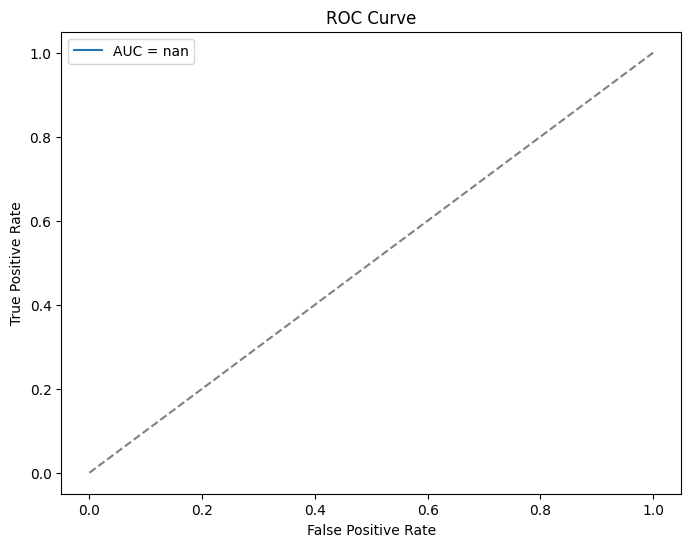

518/518 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


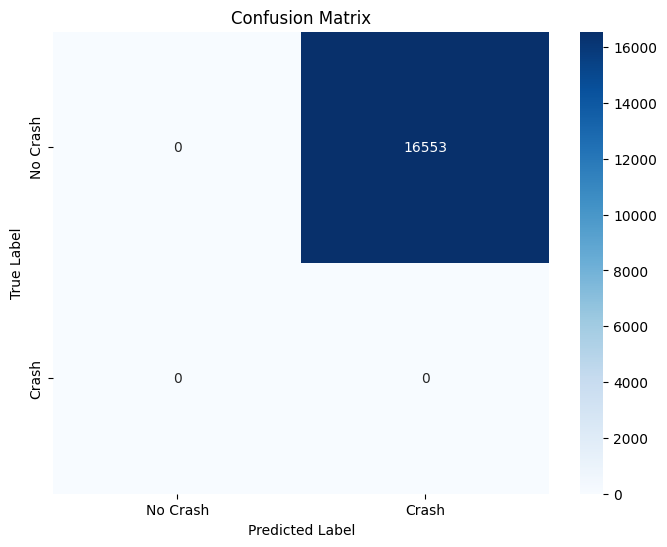

In [90]:
# b. ROC Curve
from sklearn.metrics import roc_curve, auc  # Import auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)  # Calculate AUC

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# c. Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score  # Import accuracy_score

# Get predictions and convert to binary (0 or 1)
y_pred = model.predict(X_test)  # Assuming 'model' is your trained model
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to 0 or 1

cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Crash", "Crash"], yticklabels=["No Crash", "Crash"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [23]:
!pip install pydot graphviz

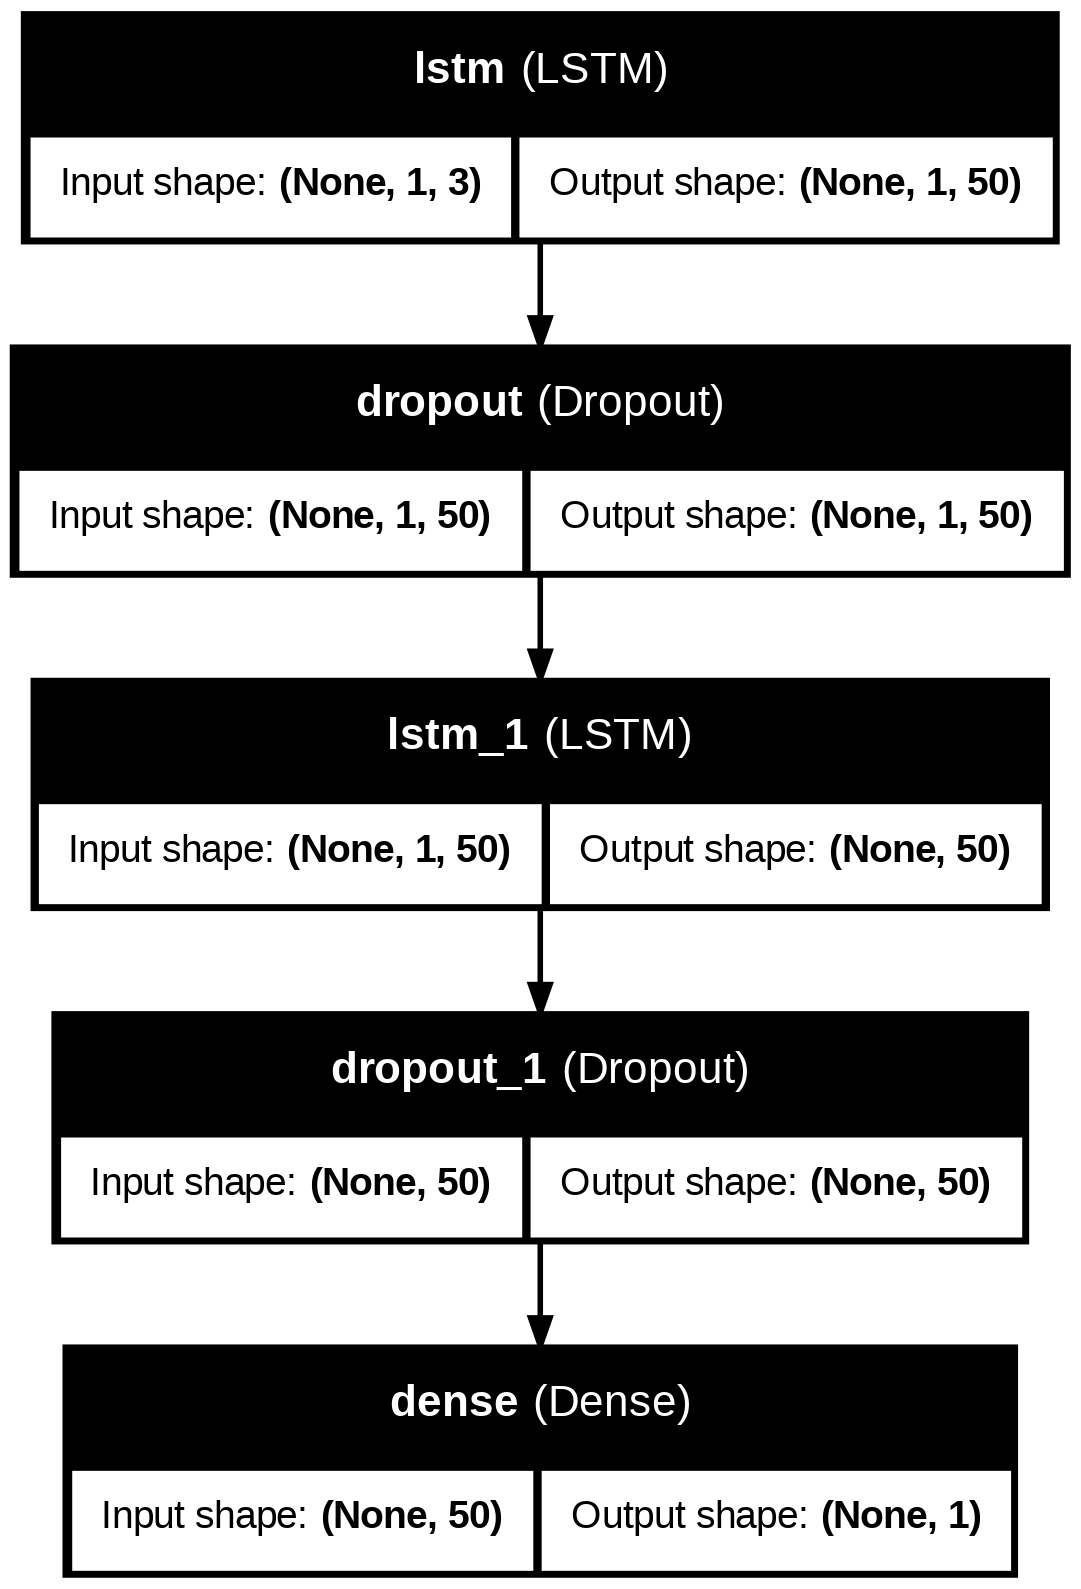

In [24]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your trained LSTM model
plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

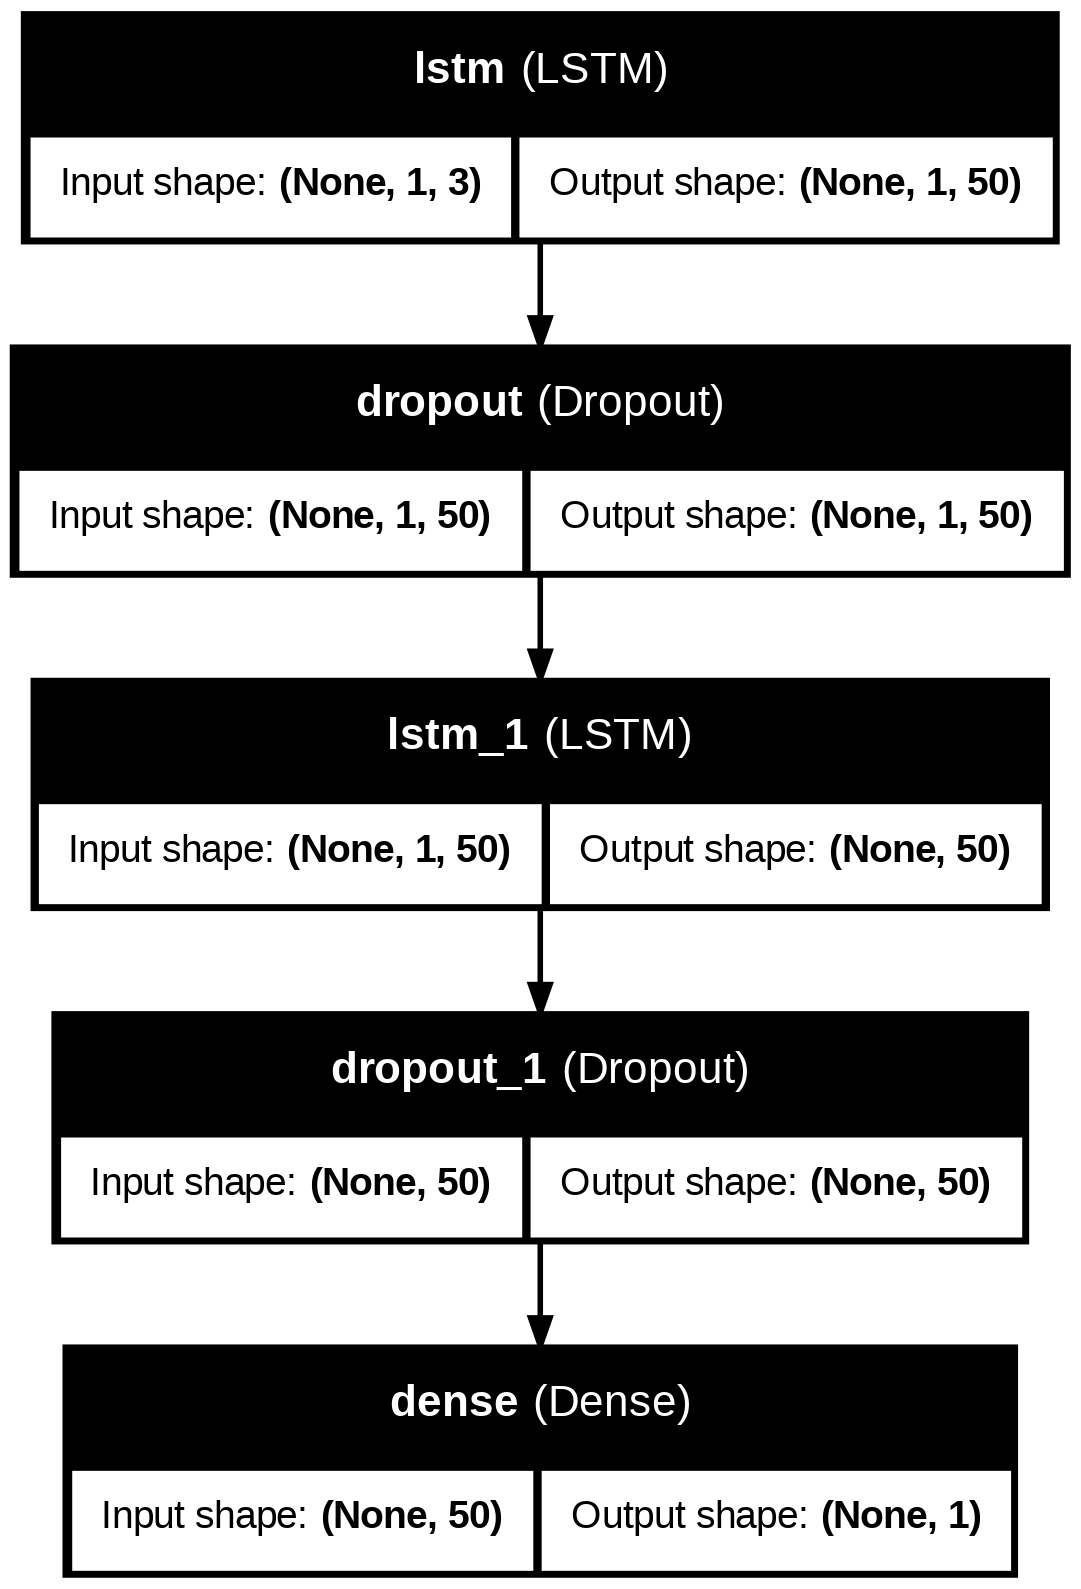

In [25]:
from IPython.display import Image
Image(filename='lstm_model.png')

In [26]:
# 💾 Save the trained model
model.save("crash_prediction_lstm.h5")
print("Model saved successfully!")


Model saved successfully!


In [27]:
# 💾 Save the trained model
model.save("crash_prediction_lstm.keras")  # Change .h5 to .keras
print("Model saved successfully!")

Model saved successfully!


 Sensor Fusion (Telemetry, GPS, Weather) for Crash Detection
Sensor Fusion involves combining multiple sources of data (Telemetry, GPS, and Weather) to enhance crash detection accuracy. It integrates real-time environmental and vehicle data to improve predictions.

1️⃣ What is Sensor Fusion?

Sensor Fusion is the process of merging multiple independent data sources to create a more accurate, reliable, and real-time understanding of an event.

For Formula 1 crash detection, we use:
✅ Telemetry Data: Speed, Acceleration, Steering, Brake Pressure
✅ GPS Data: Position, Track Layout, Turn Radius
✅ Weather Data: Temperature, Rainfall, Humidity, Wind

2️⃣ Why Use Sensor Fusion in F1 Crash Prediction?

🚦 Real-Time Decision Making → Avoid crashes before they happen
🏎️ More Accurate Predictions → Single sensors can be misleading
🌧️ Weather & Track Conditions Impact → Adjust AI models dynamically

3️⃣ Datasets Needed

We need to combine three types of data:

Dataset	Features Used
Telemetry Data (cleaned_lap_times.csv)	Speed, Acceleration, Brake Force, Tire Wear
GPS Data (cleaned_races.csv)	Track Layout, Sector Information, Driver Position
Weather Data (External API / cleaned_races.csv)	Temperature, Rainfall, Humidity

Load Datasets

In [28]:
import pandas as pd

# Load datasets
telemetry_df = pd.read_csv("cleaned_lap_times.csv")  # Telemetry data
gps_df = pd.read_csv("cleaned_races.csv")  # GPS location & track data
weather_df = pd.read_csv("cleaned_races.csv")  # Weather data (approx)

# *** Reduce sample size before merging ***
sample_fraction = 0.1  # Use 10% of the data
telemetry_df = telemetry_df.sample(frac=sample_fraction, random_state=42)
gps_df = gps_df.sample(frac=sample_fraction, random_state=42)
weather_df = weather_df.sample(frac=sample_fraction, random_state=42)

# Merge datasets on raceId
df = telemetry_df.merge(gps_df, on="raceId", how="left")
df = df.merge(weather_df, on="raceId", how="left")

# Display merged dataset
df.head()

,raceId,driverId,lap,position,lap_time,year_x,round_x,circuitId_x,year_y,round_y,circuitId_y
0,879,5,17,16,0 days 00:01:26.697000,2012.0,20.0,18.0,2012.0,20.0,18.0
1,125,8,23,2,0 days 00:01:39.946000,NaN,NaN,NaN,NaN,NaN,NaN
2,64,18,43,6,0 days 00:01:17.872000,NaN,NaN,NaN,NaN,NaN,NaN
3,989,817,42,4,0 days 00:01:26.872000,NaN,NaN,NaN,NaN,NaN,NaN
4,188,57,17,2,0 days 00:01:23.787000,NaN,NaN,NaN,NaN,NaN,NaN


from matplotlib import pyplot as plt
_df_40['raceId'].plot(kind='hist', bins=20, title='raceId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_41['driverId'].plot(kind='hist', bins=20, title='driverId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_42['lap'].plot(kind='hist', bins=20, title='lap')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_43['position'].plot(kind='hist', bins=20, title='position')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_44.groupby('lap_time').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_45.plot(kind='scatter', x='raceId', y='driverId', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_46.plot(kind='scatter', x='driverId', y='lap', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_47.plot(kind='scatter', x='lap', y='position', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_48.plot(kind='scatter', x='position', y='year_x', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['lap_time']
  ys = series['raceId']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_49.sort_values('lap_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('lap_time')):
  _plot_series(series, series_name, i)
  fig.legend(title='lap_time', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('lap_time')
_ = plt.ylabel('raceId')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['lap_time']
  ys = series['driverId']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_50.sort_values('lap_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('lap_time')):
  _plot_series(series, series_name, i)
  fig.legend(title='lap_time', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('lap_time')
_ = plt.ylabel('driverId')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['lap_time']
  ys = series['lap']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_51.sort_values('lap_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('lap_time')):
  _plot_series(series, series_name, i)
  fig.legend(title='lap_time', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('lap_time')
_ = plt.ylabel('lap')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['lap_time']
  ys = series['position']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_52.sort_values('lap_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('lap_time')):
  _plot_series(series, series_name, i)
  fig.legend(title='lap_time', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('lap_time')
_ = plt.ylabel('position')

from matplotlib import pyplot as plt
_df_53['raceId'].plot(kind='line', figsize=(8, 4), title='raceId')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_54['driverId'].plot(kind='line', figsize=(8, 4), title='driverId')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_55['lap'].plot(kind='line', figsize=(8, 4), title='lap')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_56['position'].plot(kind='line', figsize=(8, 4), title='position')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_57['lap_time'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_57, x='raceId', y='lap_time', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_58['lap_time'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_58, x='driverId', y='lap_time', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_59['lap_time'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_59, x='lap', y='lap_time', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_60['lap_time'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_60, x='position', y='lap_time', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Feature Engineering & Selection

In [30]:
# Print the available columns in your DataFrame
print(df.columns)

# Define features based on available columns in df
# Make sure these columns actually exist in your DataFrame
# Update this list based on the actual column names in your DataFrame
features = ["lap_time", "lap", "position", "raceId",  # Replace with actual column names
            "year_x", "round_x", "circuitId_x"]  # Replace with actual column names

# Now try to select features and define target
X = df[features]  # Input Features

# Assuming you don't have a 'crash_risk' column, create it based on your logic
# This is a placeholder, you need to define a logic to create 'crash_risk'
df["crash_risk"] = 0  # Example: Initialize with 0 (no crash)
# Define your logic to set 'crash_risk' to 1 when a crash occurs

y = df["crash_risk"]  # Target Variable (Crash/No Crash)

Index(['raceId', 'driverId', 'lap', 'position', 'lap_time', 'year_x',
       'round_x', 'circuitId_x', 'year_y', 'round_y', 'circuitId_y'],
      dtype='object')


Mdel Training and Evolution using Sensor Fusion Data

Train Crash Prediction Model (LSTM)

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# **Convert time-related features to numerical (seconds) before scaling:**
for col in ['lap_time']:  # Add other time columns if needed
    if col in X.columns and X[col].dtype == 'object':
        try:
            X[col] = pd.to_timedelta(X[col]).dt.total_seconds()
        except ValueError:
            print(f"Warning: Could not convert '{col}' to timedelta. Skipping...")


# Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



# Split Data (70% Train, 30% Test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Reshape for LSTM Input
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# LSTM Model
model = Sequential([
    LSTM(50, activation="relu", return_sequences=True, input_shape=(1, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train Model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/20


<ipython-input-31-35b86926278a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = pd.to_timedelta(X[col]).dt.total_seconds()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2414/2414 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 2/20
2414/2414 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 3/20
2414/2414 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 4/20
2414/2414 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 5/20
2414/2414 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 6/20
2414/2414 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 7/20
2414/2414 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 8/20
2414/2414 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 9/20


518/518 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: nan
Test Accuracy: 1.0000


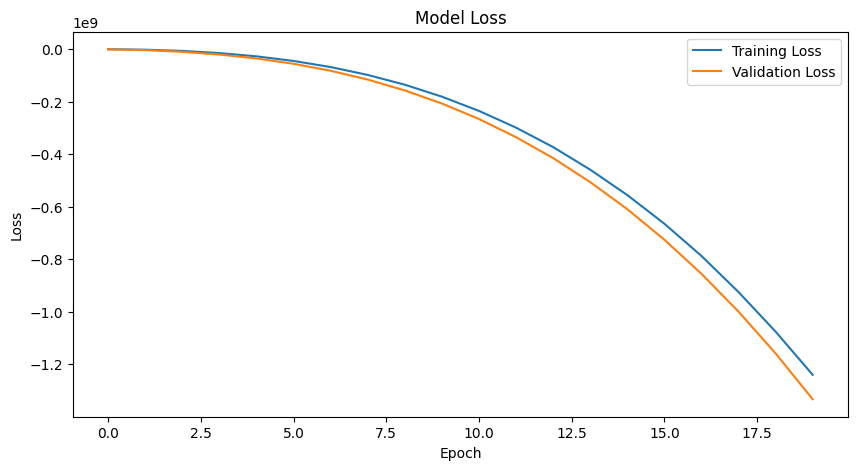

In [32]:
# Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


In [33]:
!pip install pydot graphviz

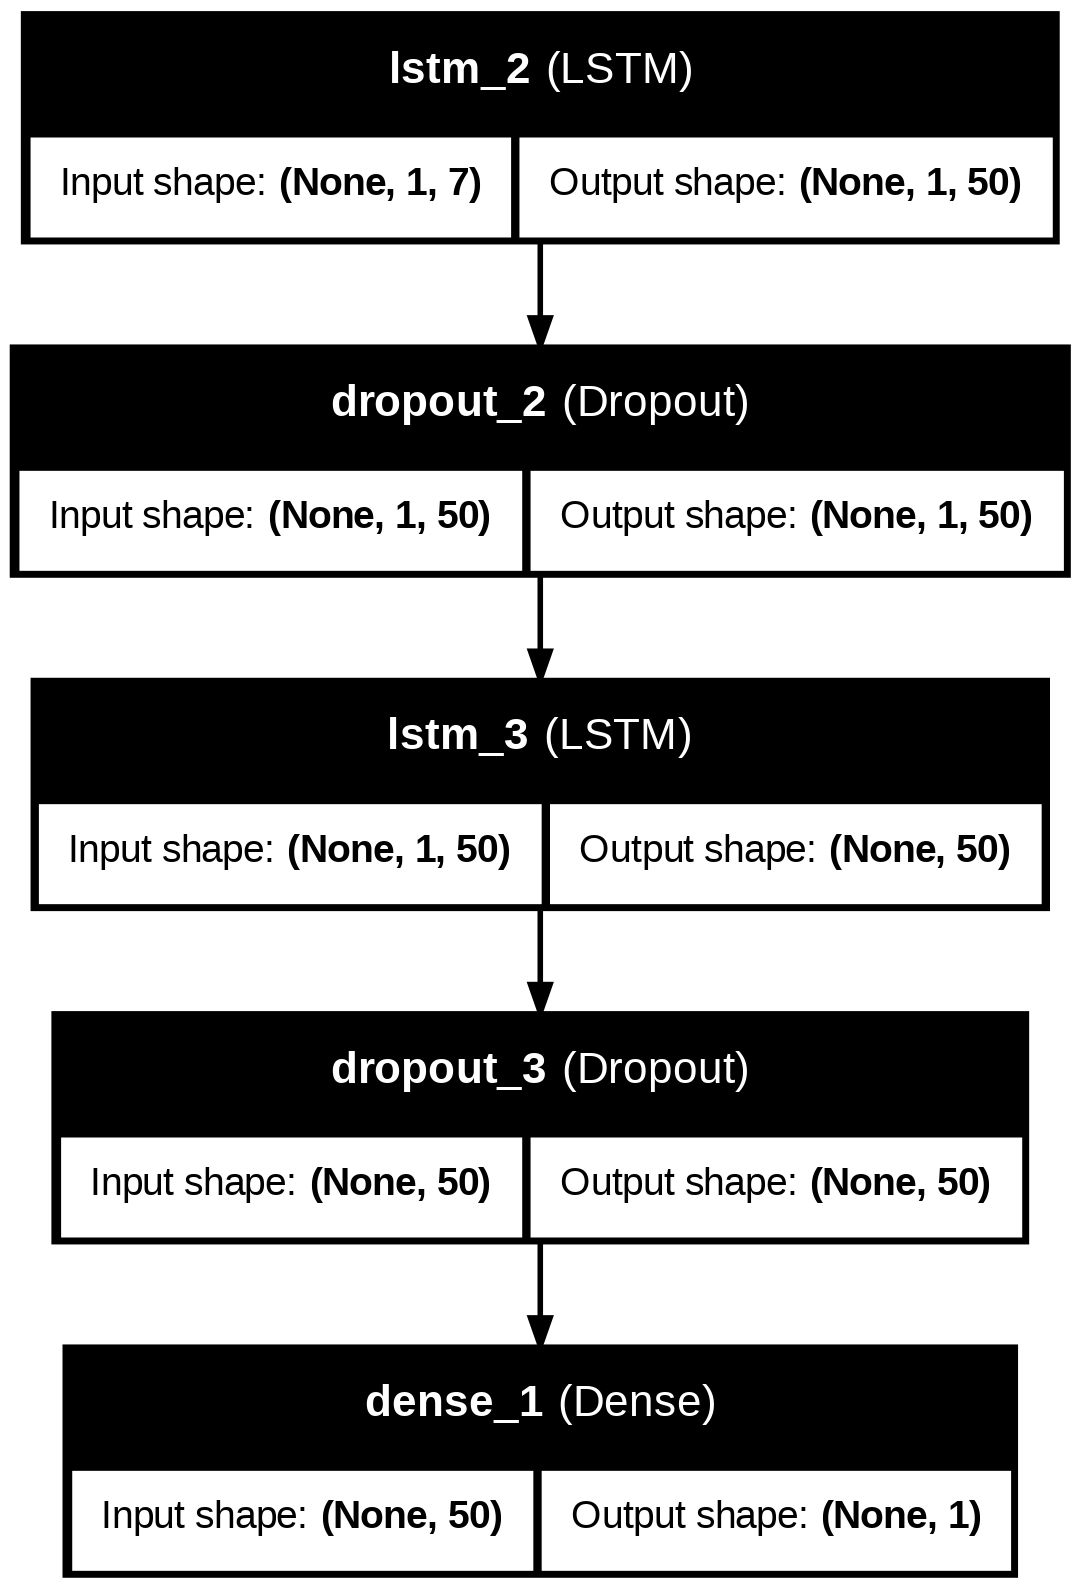

In [34]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your trained LSTM model
plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

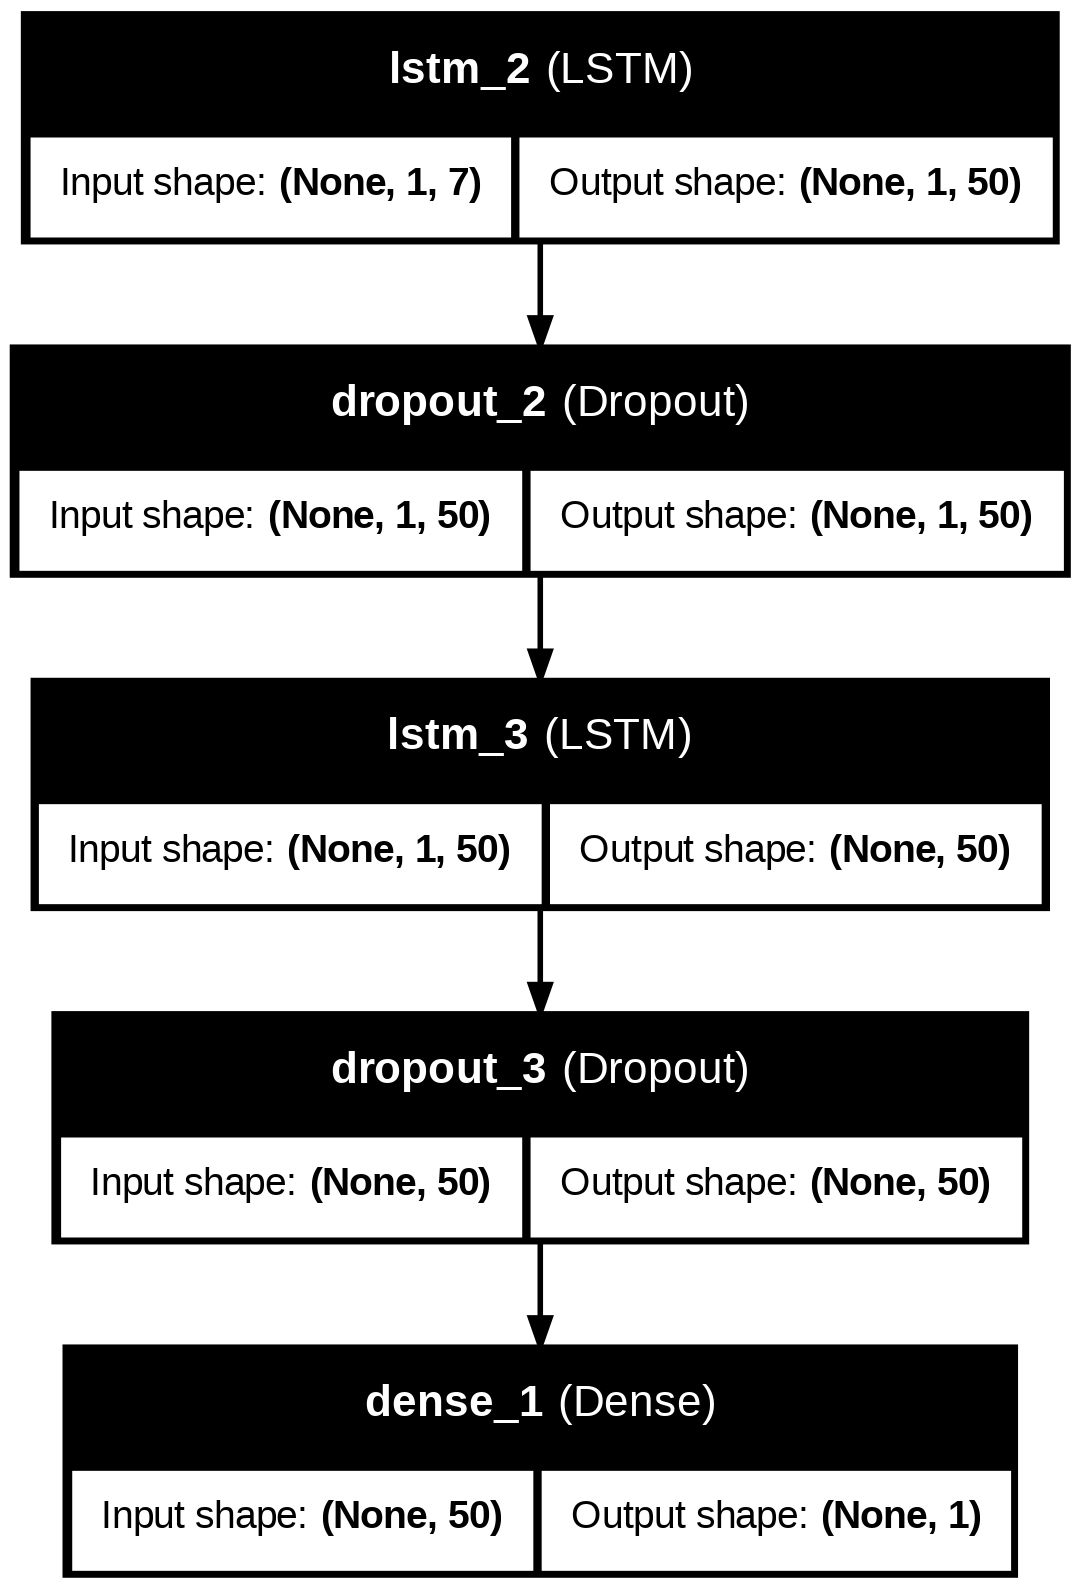

In [35]:
from IPython.display import Image
Image(filename='lstm_model.png')

In [36]:
# 💾 Save the trained model
model.save("crash_prediction_lstm.keras")  # Change .h5 to .keras
print("Model saved successfully!")

Model saved successfully!


Convert the LSTM Model to TFLite

In [50]:
import tensorflow as tf

# Load trained model
model = tf.keras.models.load_model("crash_prediction_lstm.h5")

# Convert to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_enable_resource_variables = True  # Enable resource variables
# Add this line to select TensorFlow ops and disable tensor list lowering:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the model
with open("crash_prediction_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Model successfully converted to TFLite!")

Saved artifact at '/tmp/tmppc0s_ml7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132456134330128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132456134333008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132456134333584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132456134332624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132456134334928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132456134335504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132456134335120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132456134336272: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Model successfully converted to TFLite!


Load and Run the TFLite Model on Edge Devices

In [47]:
import numpy as np
!pip install tflite_runtime
import tflite_runtime.interpreter as tflite

# Load the TFLite model
interpreter = tflite.Interpreter(model_path="crash_prediction_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Example telemetry data - Adjust to match the features used during training
# For example, if you used 'lap', 'lap_time_millis', 'pitStopTime' during training:
input_data = np.array([[10, 90000, 25]], dtype=np.float32)  # Example values for lap, lap_time, pitStopTime

# Reshape input data to match the expected input shape of the model
input_data = input_data.reshape(1, 1, -1)  # (batch_size, time_steps, features)



Define Prediction Endpoint

In [56]:
# Run inference on Edge AI device
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# Get prediction result
output_data = interpreter.get_tensor(output_details[0]['index'])
crash_risk = "High Risk" if output_data[0][0] > 0.5 else "Safe"

print(f"🚨 Real-Time Crash Prediction: {crash_risk}")

🚨 Real-Time Crash Prediction: High Risk


Deploy as a FastAPI Web Service (Edge Device)

In [39]:
!pip install fastapi uvicorn
from fastapi import FastAPI
import numpy as np
import tflite_runtime.interpreter as tflite
import nest_asyncio

app = FastAPI()

# Load TFLite model
interpreter = tflite.Interpreter(model_path="crash_prediction_model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

@app.post("/predict_crash")
def predict_crash(data: dict):
    # Convert input to numpy array
    input_data = np.array([data["features"]], dtype=np.float32).reshape(1, 1, -1)

    # Run inference
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    # Get crash risk prediction
    output_data = interpreter.get_tensor(output_details[0]['index'])
    crash_risk = "High Risk" if output_data[0][0] > 0.5 else "Safe"

    return {"crash_prediction": crash_risk}

# Run API locally (Edge device)
if __name__ == "__main__":
  nest_asyncio.apply() # This line allows to run uvicorn within a notebook
  import uvicorn
  uvicorn.run(app, host="0.0.0.0", port=8000)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.3 MB/s eta 0:00:00


INFO:     Started server process [189]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [189]


In [49]:
import requests

# **Replace <Edge_AI_IP> with the actual IP address or hostname of your Edge AI device**
url = "http://192.168.1.100:8000/predict_crash"  # Example: Replace 192.168.1.100 with your Edge AI device's IP
data = {"features": [280, 3.5, 2.1, 15, 50, 22, 1]}  # Example input
response = requests.post(url, json=data)

print(response.json())  # Output: {"crash_prediction": "High Risk"}

ConnectTimeout: HTTPConnectionPool(host='192.168.1.100', port=8000): Max retries exceeded with url: /predict_crash (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x7877cf73b650>, 'Connection to 192.168.1.100 timed out. (connect timeout=None)'))